In [ ]:
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
! pip install pyspark >& /dev/null

In [ ]:
# Create Spark Session and Spark Context
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDA-PROJECT').getOrCreate()
sc = spark.sparkContext

In [ ]:
%%bash

file_id="1AD5238P0CEsLfr3AqI2vI3LcMNV8kLNc"
file_name="airline-departure-delays.csv"

if [ ! -f "$file_name" ]; then
    # Create a direct download link
    direct_link="https://drive.google.com/uc?id=$file_id"

    # Download the file
    wget --no-check-certificate "$direct_link" -O "$file_name" -q
fi

In [ ]:
data_path = "airline-departure-delays.csv"

data = spark.read.format('csv')\
  .option('header', 'true')\
  .load(data_path)

data.show()

+---------+---------+-------------------+-------------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+------+------------------+---------------+--------------+----------+------------+
|Flight_ID|  Airline|     Departure_City|       Arrival_City|Distance|Departure_Time|Arrival_Time|Duration|Aircraft_Type|Number_of_Stops|Day_of_Week|Month_of_Travel|Holiday_Season|Demand|Weather_Conditions|Passenger_Count|Promotion_Type|Fuel_Price|Flight_Price|
+---------+---------+-------------------+-------------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+------+------------------+---------------+--------------+----------+------------+
|       F1|Airline B|               NULL|         Greenshire|    8286|          8:23|       20:19|   11.94|   Boeing 787|              0|  Wednesday|       December|        Summer|   Low|              Rain|        

Creating a temporary sql table from data frame

In [ ]:
data.createOrReplaceTempView('train_data')

In [ ]:
spark.sql('SELECT count(*) AS count_of_train_data from train_data').show()

+-------------------+
|count_of_train_data|
+-------------------+
|              45000|
+-------------------+



In [ ]:
from pyspark.sql.functions import col, sum, when

# List of columns
columns = ['Airline', 'Departure_City', 'Arrival_City', 'Distance', 'Departure_Time', 'Arrival_Time', 'Duration',
           'Aircraft_Type', 'Number_of_Stops', 'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Demand',
           'Weather_Conditions', 'Passenger_Count', 'Promotion_Type', 'Fuel_Price', 'Flight_Price']

# Compute null counts for each column
null_counts = data.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(f'nulls_in_{c}') for c in columns])

null_counts.show(truncate=False)


+----------------+-----------------------+---------------------+-----------------+-----------------------+---------------------+-----------------+----------------------+------------------------+--------------------+------------------------+-----------------------+---------------+---------------------------+------------------------+-----------------------+-------------------+---------------------+
|nulls_in_Airline|nulls_in_Departure_City|nulls_in_Arrival_City|nulls_in_Distance|nulls_in_Departure_Time|nulls_in_Arrival_Time|nulls_in_Duration|nulls_in_Aircraft_Type|nulls_in_Number_of_Stops|nulls_in_Day_of_Week|nulls_in_Month_of_Travel|nulls_in_Holiday_Season|nulls_in_Demand|nulls_in_Weather_Conditions|nulls_in_Passenger_Count|nulls_in_Promotion_Type|nulls_in_Fuel_Price|nulls_in_Flight_Price|
+----------------+-----------------------+---------------------+-----------------+-----------------------+---------------------+-----------------+----------------------+------------------------+------

Here we are imputing null values:

For Airlines we don't want to consider missing airline company for any particular company which our results have chances of bias, so we consider it separate category as "Missing"

For the distance we have imputed with median value.

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import DoubleType

data.createOrReplaceTempView("train_data_temp")
categorical_columns = ['Airline', 'Departure_City', 'Arrival_City', 'Demand', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel','Holiday_Season','Weather_Conditions','Promotion_Type']
for column in categorical_columns:
    data = data.withColumn(column, when(col(column).isNull(), 'Missing').otherwise(col(column)))

numerical_columns = ['Distance', 'Fuel_Price']
medians = {}
for column in numerical_columns:
  data = data.withColumn(column, data[column].cast(DoubleType()))
  medians[column] = data.filter(col(column).isNotNull()).approxQuantile(column, [0.5], 0.0)[0]

data = data.na.fill(medians)

data.createOrReplaceTempView("train_clean_data")


Categorical columns are 'Airline', 'Departure_City', 'Arrival_City', 'Demand', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel','Holiday_Season','Weather_Conditions'

Numerical columns are 'Distance', 'Fuel_Price'

In [ ]:
from pyspark.sql.functions import col, sum, when

# List of columns
columns = ['Airline', 'Departure_City', 'Arrival_City', 'Distance', 'Departure_Time', 'Arrival_Time', 'Duration',
           'Aircraft_Type', 'Number_of_Stops', 'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Demand',
           'Weather_Conditions', 'Passenger_Count', 'Promotion_Type', 'Fuel_Price', 'Flight_Price']

# Compute null counts for each column
null_counts = data.agg(*[sum(when(col(c).isNull(), 1).otherwise(0)).alias(f'nulls_in_{c}') for c in columns])

null_counts.show(truncate=False)


+----------------+-----------------------+---------------------+-----------------+-----------------------+---------------------+-----------------+----------------------+------------------------+--------------------+------------------------+-----------------------+---------------+---------------------------+------------------------+-----------------------+-------------------+---------------------+
|nulls_in_Airline|nulls_in_Departure_City|nulls_in_Arrival_City|nulls_in_Distance|nulls_in_Departure_Time|nulls_in_Arrival_Time|nulls_in_Duration|nulls_in_Aircraft_Type|nulls_in_Number_of_Stops|nulls_in_Day_of_Week|nulls_in_Month_of_Travel|nulls_in_Holiday_Season|nulls_in_Demand|nulls_in_Weather_Conditions|nulls_in_Passenger_Count|nulls_in_Promotion_Type|nulls_in_Fuel_Price|nulls_in_Flight_Price|
+----------------+-----------------------+---------------------+-----------------+-----------------------+---------------------+-----------------+----------------------+------------------------+------

In [ ]:
# Descriptive statistics for numerical columns
data.describe(['Distance', 'Fuel_Price', 'Flight_Price']).show()

# Frequency counts for categorical columns
for column in categorical_columns:
    data.groupBy(column).count().orderBy('count', ascending=False).show()


+-------+------------------+------------------+------------------+
|summary|          Distance|        Fuel_Price|      Flight_Price|
+-------+------------------+------------------+------------------+
|  count|             45000|             45000|             45000|
|   mean| 5482.226111111111|0.8501915555555469| 574.6062697777792|
| stddev|2592.2228098483624|0.2015346325351894|160.23934361201927|
|    min|            1000.0|               0.5|           1000.31|
|    max|           10000.0|               1.2|            999.98|
+-------+------------------+------------------+------------------+

+---------+-----+
|  Airline|count|
+---------+-----+
|Airline A|13863|
|Airline C|13809|
|Airline B|13755|
|  Missing| 3573|
+---------+-----+

+----------------+-----+
|  Departure_City|count|
+----------------+-----+
|         Missing|  340|
|    Port Michael|   49|
|    West Michael|   47|
|   North Michael|   42|
|   South Michael|   40|
|      Lake David|   39|
|     North David|   39|
|

**Distribution of numerical columns**

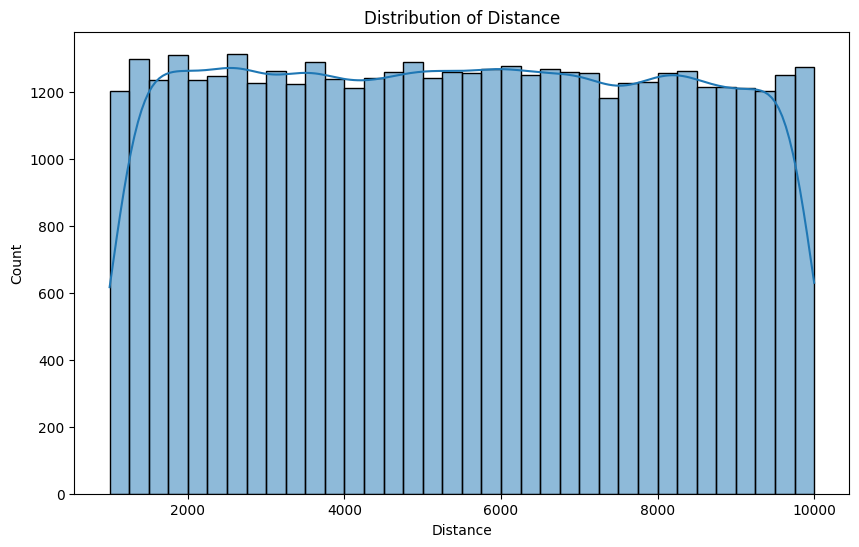

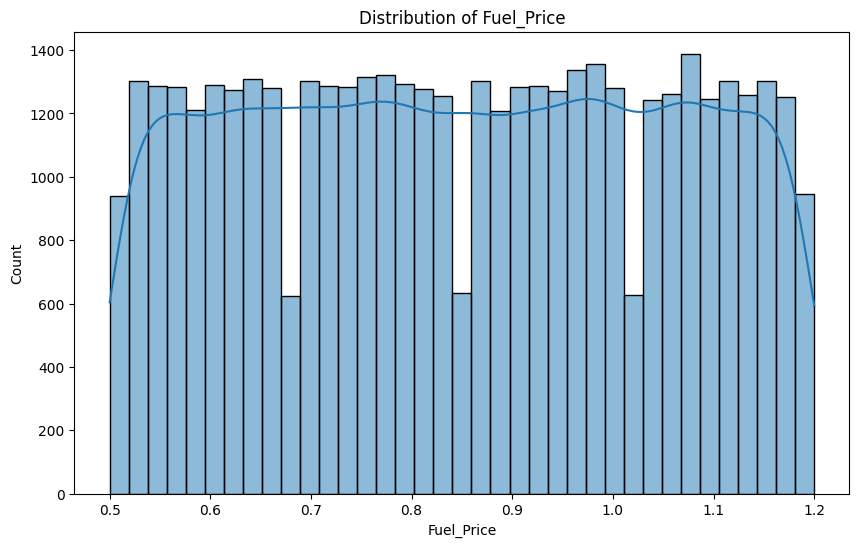

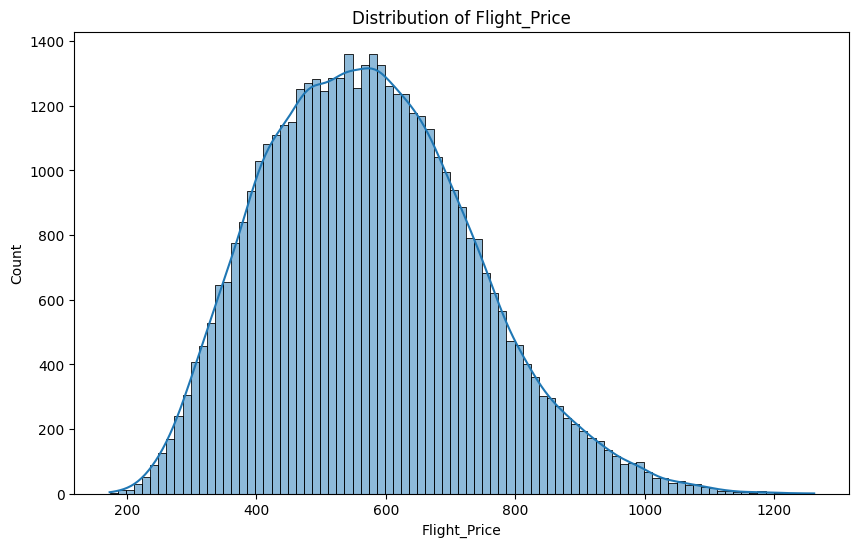

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("airline-departure-delays.csv")
for column in ['Distance', 'Fuel_Price', 'Flight_Price']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


**Frequency plots for categorical columns**

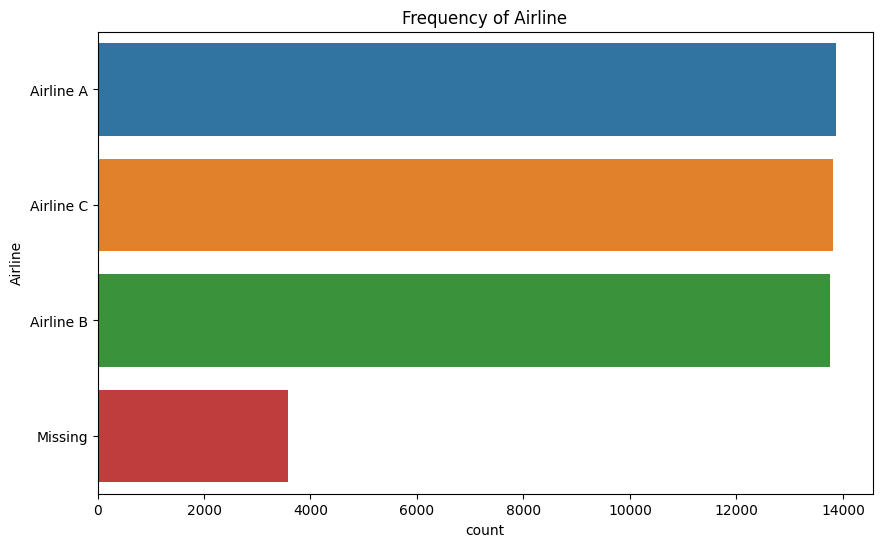

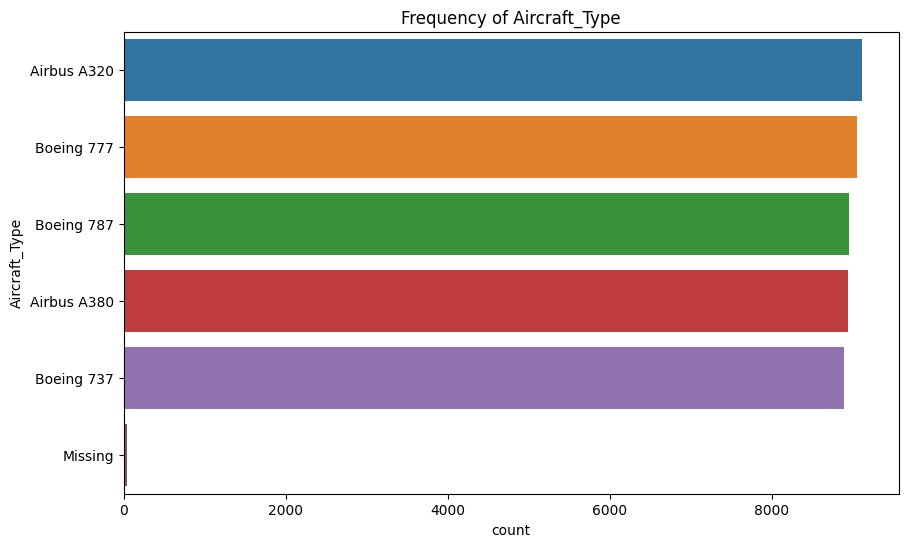

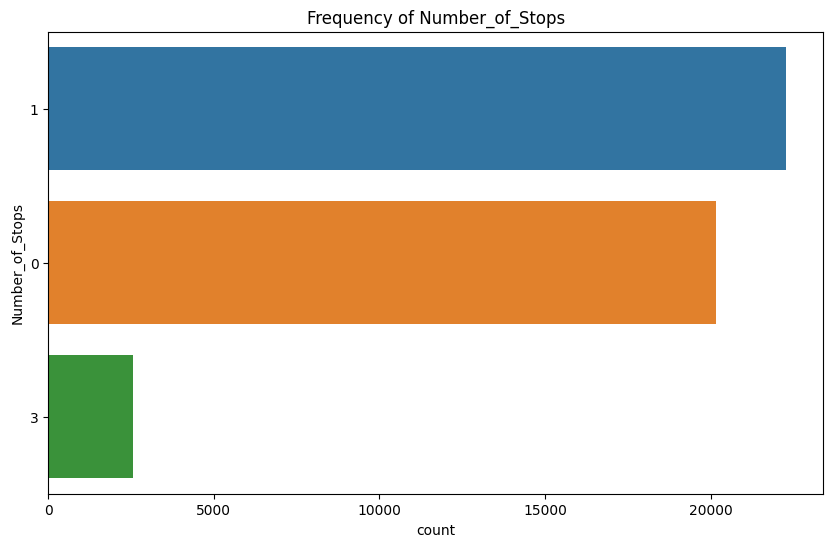

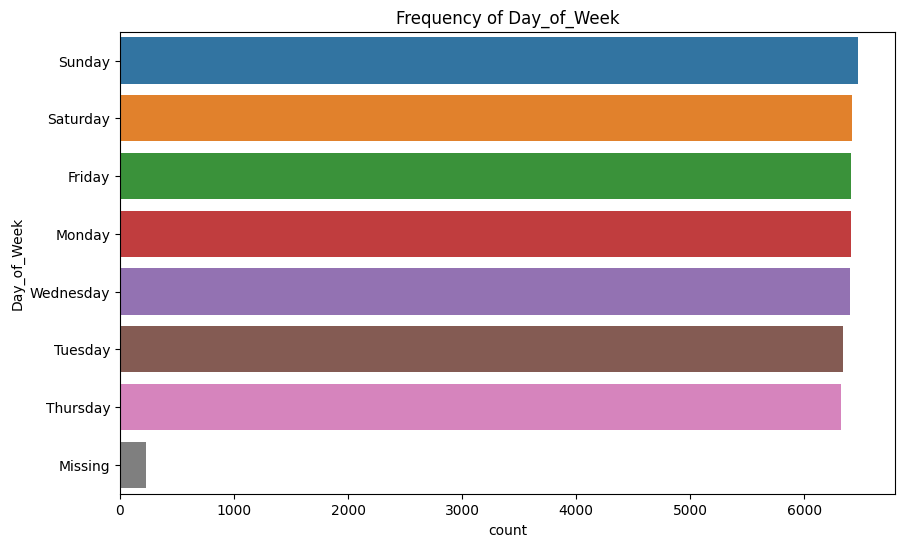

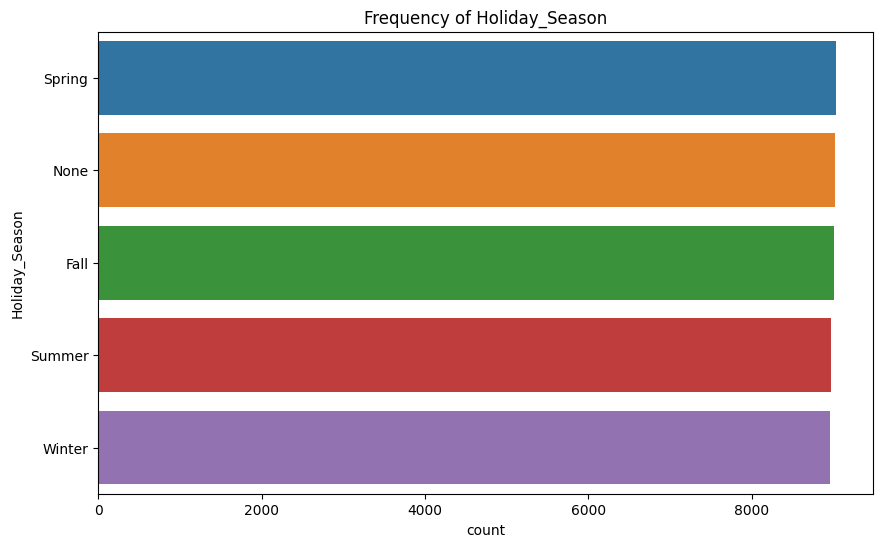

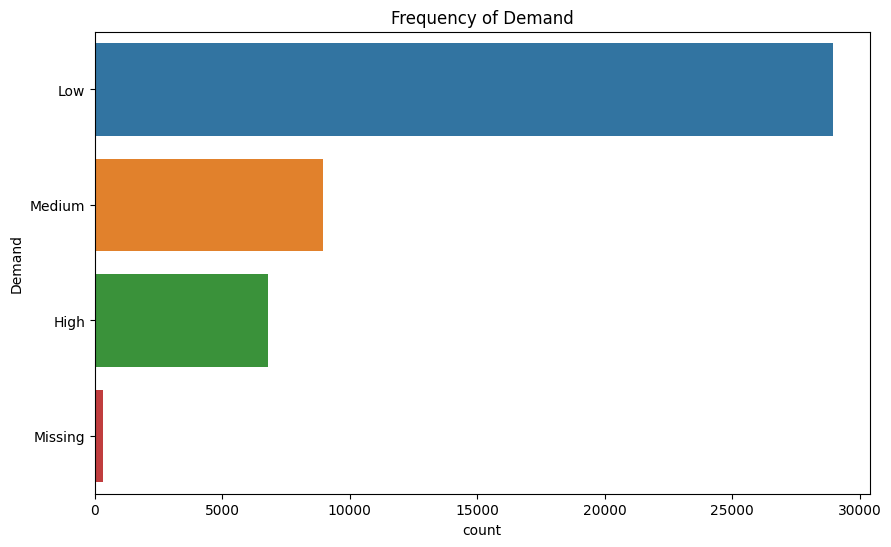

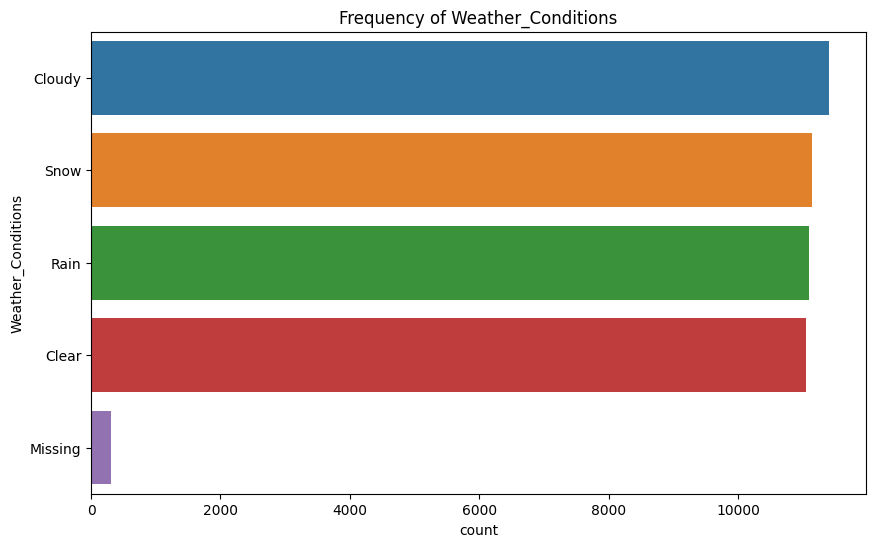

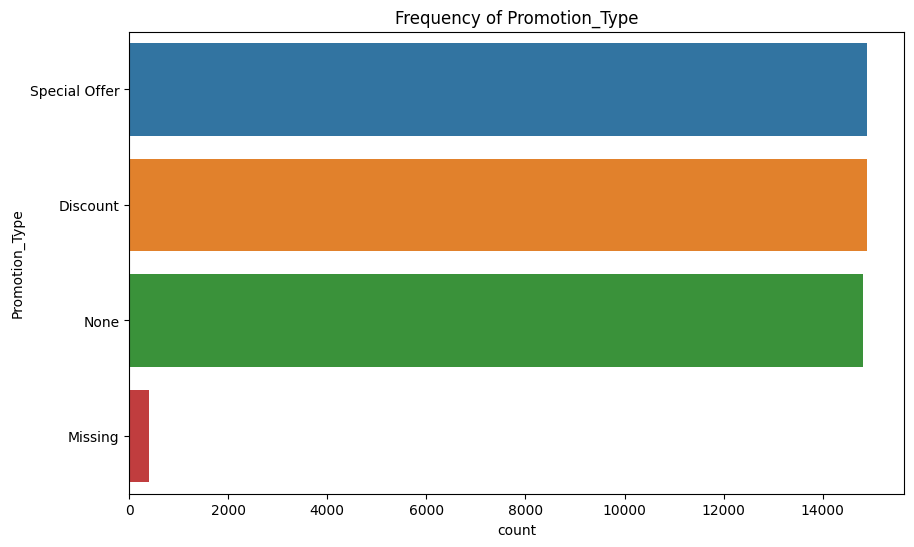

In [ ]:
pdf = data.toPandas()
c_columns = ['Airline', 'Aircraft_Type', 'Number_of_Stops', 'Day_of_Week','Holiday_Season', 'Demand',
           'Weather_Conditions', 'Promotion_Type']
for column in c_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=pdf, y=column, order=pdf[column].value_counts().index)
    plt.title(f'Frequency of {column}')
    plt.show()


**Boxplots for numerical data against some categorical variables**

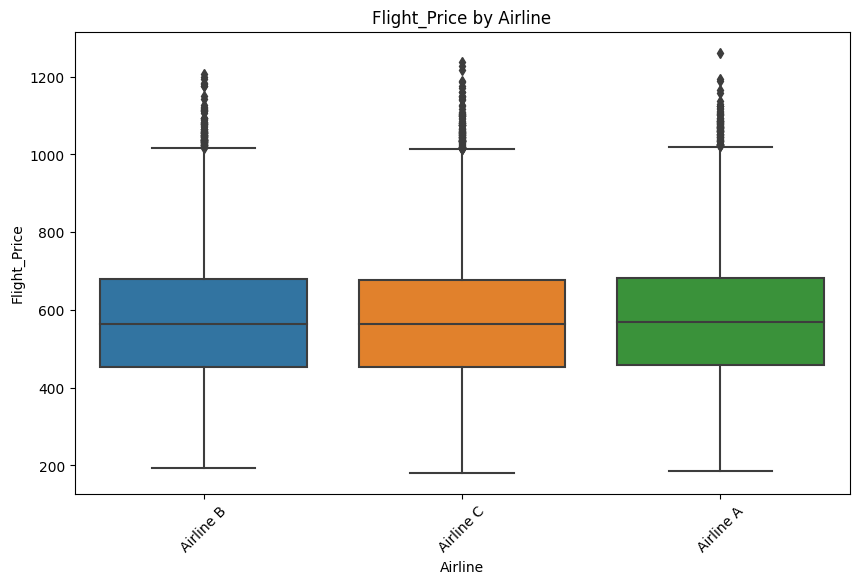

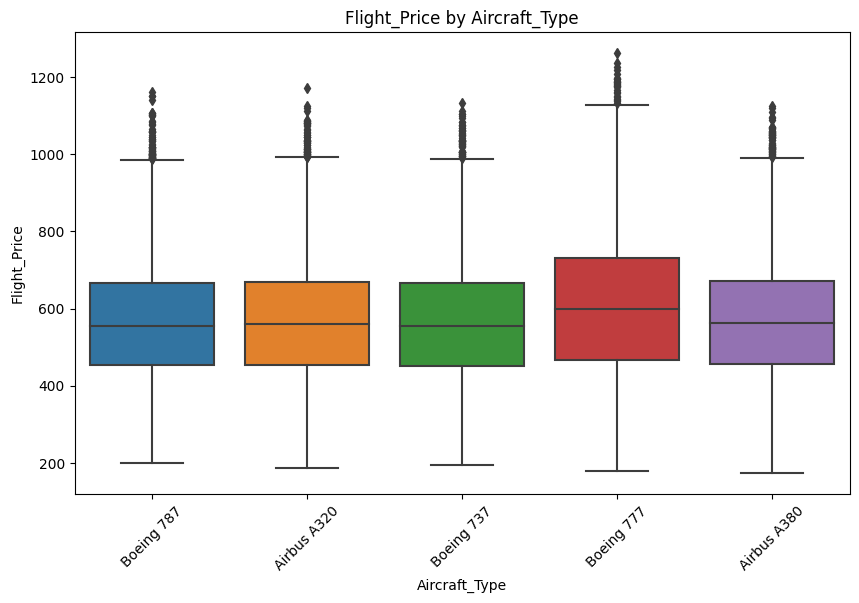

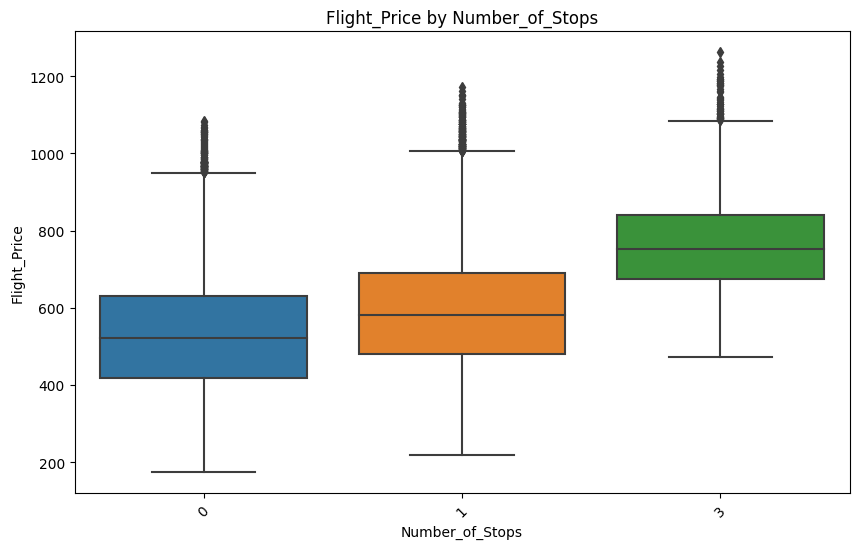

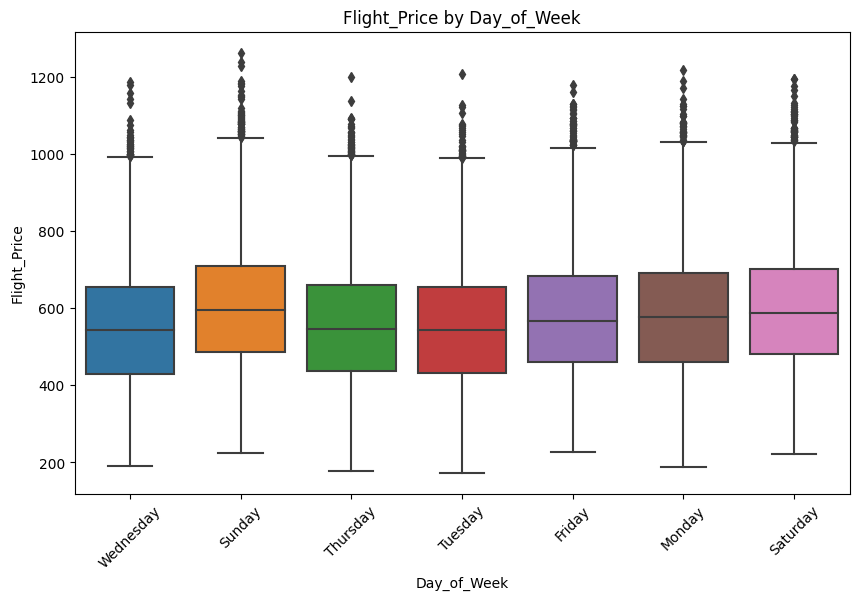

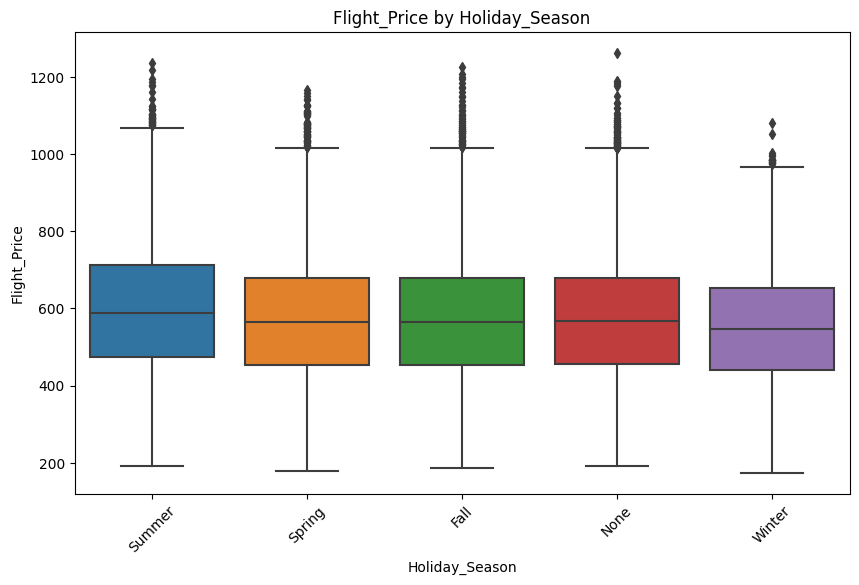

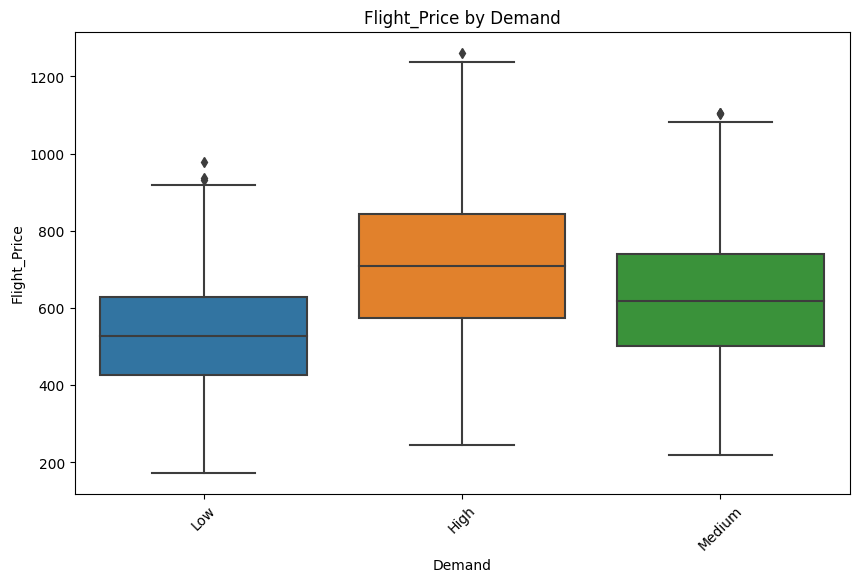

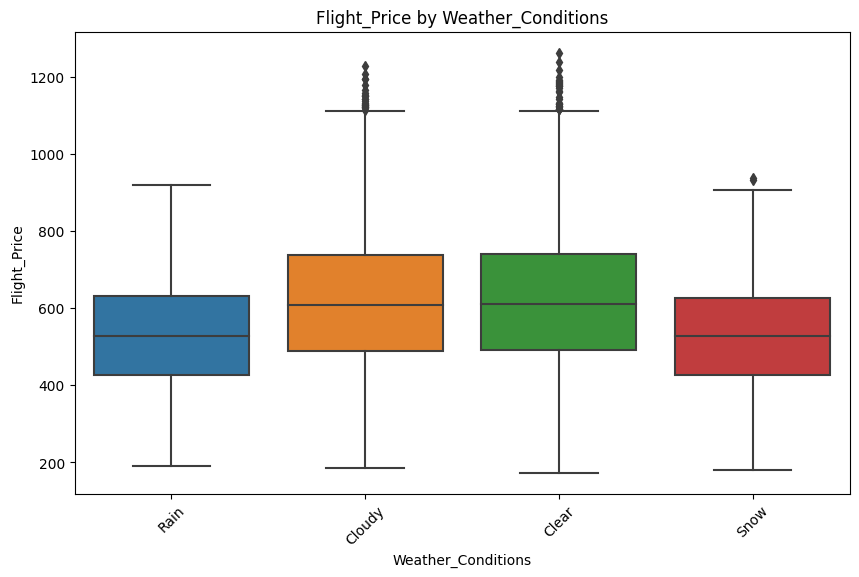

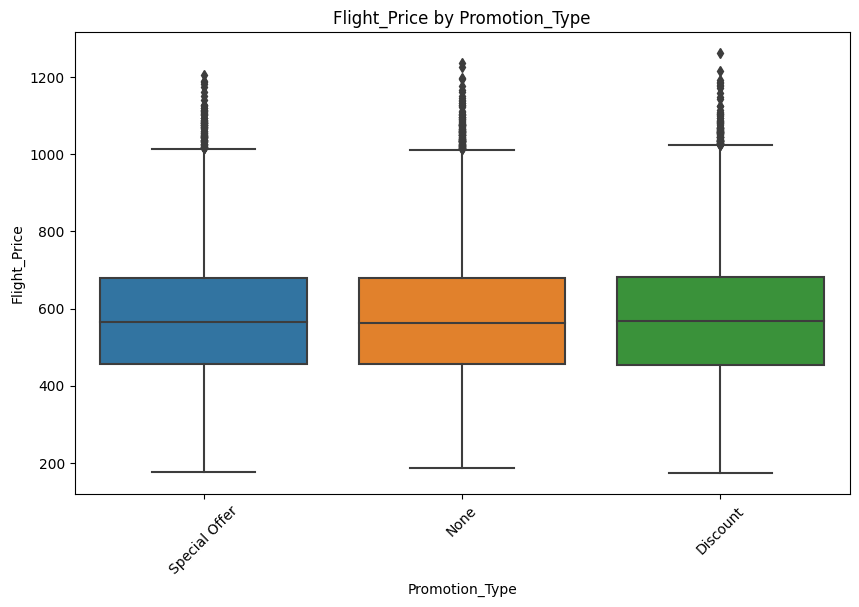

In [ ]:
for column in c_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=column, y='Flight_Price')
    plt.title(f'Flight_Price by {column}')
    plt.xticks(rotation=45)
    plt.show()

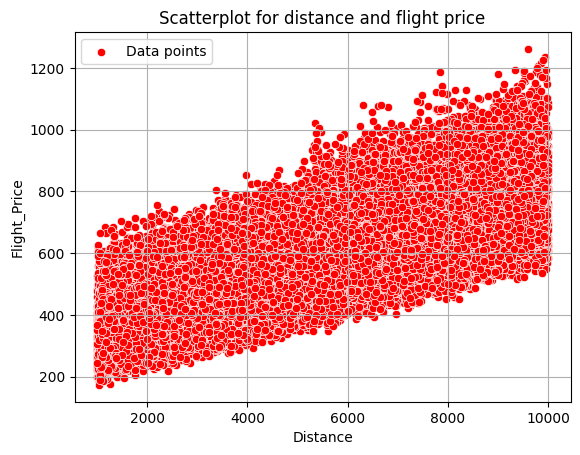

In [ ]:
sns.scatterplot(x='Distance', y='Flight_Price', data=df, color='red', label='Data points')
plt.title('Scatterplot for distance and flight price')
plt.grid(True)
plt.show()

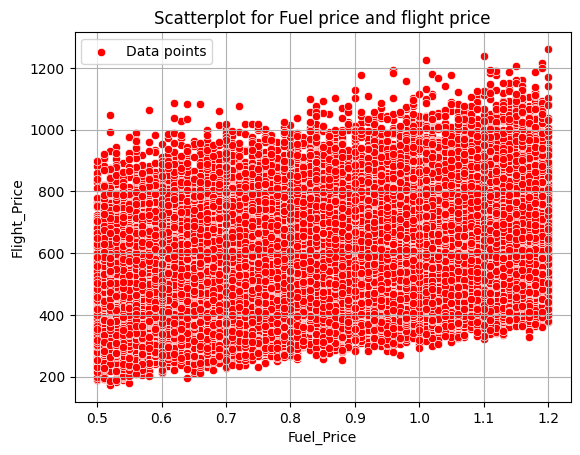

In [ ]:
sns.scatterplot(x='Fuel_Price', y='Flight_Price', data=df, color='red', label='Data points')
plt.title('Scatterplot for Fuel price and flight price')
plt.grid(True)
plt.show()

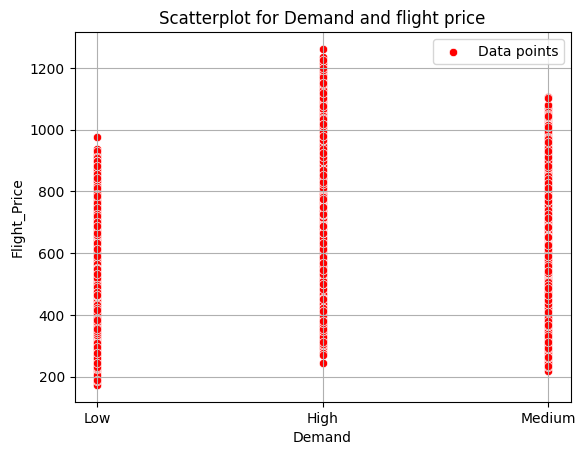

In [ ]:
sns.scatterplot(x='Demand', y='Flight_Price', data=df, color='red', label='Data points')
plt.title('Scatterplot for Demand and flight price')
plt.grid(True)
plt.show()

**Feature Engineering**

As we already imputed all null values based on their variablility in data

In [ ]:
# creating a new column name fuel price distance

from pyspark.sql.functions import col

data = data.withColumn("fuel_price_distance", col("fuel_price") * col("distance"))
data.show(5)

+---------+---------+----------------+---------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+
|Flight_ID|  Airline|  Departure_City|   Arrival_City|Distance|Departure_Time|Arrival_Time|Duration|Aircraft_Type|Number_of_Stops|Day_of_Week|Month_of_Travel|Holiday_Season| Demand|Weather_Conditions|Passenger_Count|Promotion_Type|Fuel_Price|Flight_Price|fuel_price_distance|
+---------+---------+----------------+---------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+
|       F1|Airline B|         Missing|     Greenshire|  8286.0|          8:23|       20:19|   11.94|   Boeing 787|              0|  Wednesday|       December|        Summer

This new column represents total fuel cost contribution ot the ticket price, greater the distance a plane travels, and the higher the fuel price, the higher the operational cost, which should be reflected in the price of the ticket.

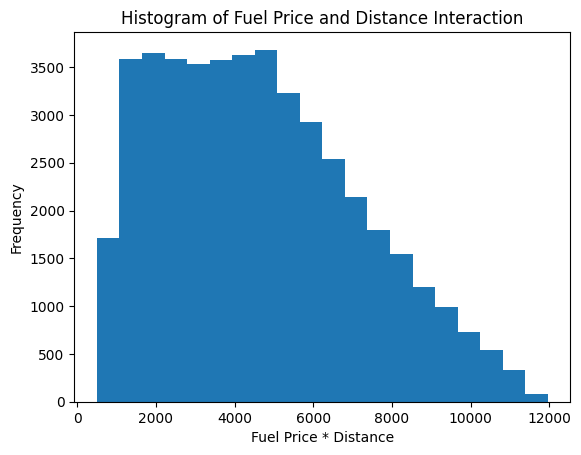

In [ ]:
#plotting histogram for the new column
fuel_price_distance_data = data.select("fuel_price_distance").rdd.flatMap(lambda x: x).collect()
plt.hist(fuel_price_distance_data, bins=20)
plt.title('Histogram of Fuel Price and Distance Interaction')
plt.xlabel('Fuel Price * Distance')
plt.ylabel('Frequency')
plt.show()

The histogram shows the data is right skewed and we need to perform square root transformation to make data distrubution normally.

In [ ]:
from pyspark.sql.functions import sqrt

# Apply a square root transformation
data = data.withColumn("sqrt_fuel_price_distance", sqrt(col("fuel_price_distance")))

data.show(5)


+---------+---------+----------------+---------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+------------------------+
|Flight_ID|  Airline|  Departure_City|   Arrival_City|Distance|Departure_Time|Arrival_Time|Duration|Aircraft_Type|Number_of_Stops|Day_of_Week|Month_of_Travel|Holiday_Season| Demand|Weather_Conditions|Passenger_Count|Promotion_Type|Fuel_Price|Flight_Price|fuel_price_distance|sqrt_fuel_price_distance|
+---------+---------+----------------+---------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+------------------------+
|       F1|Airline B|         Missing|     Greenshire|  8286.0|          8:23|       20:19|   11.

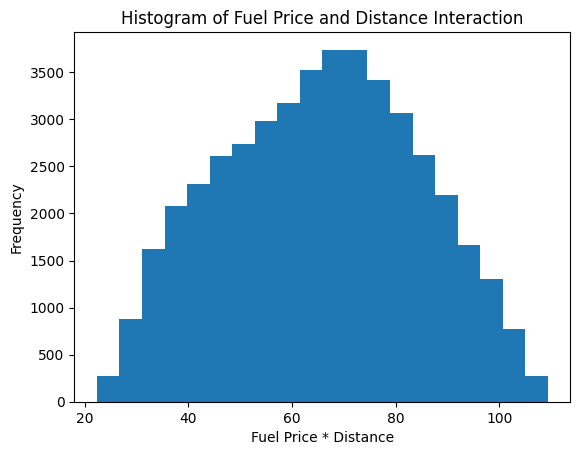

In [ ]:
#plotting histogram for the new column
fuel_price_distance_data = data.select("sqrt_fuel_price_distance").rdd.flatMap(lambda x: x).collect()
plt.hist(fuel_price_distance_data, bins=20)
plt.title('Histogram of Fuel Price and Distance Interaction')
plt.xlabel('Fuel Price * Distance')
plt.ylabel('Frequency')
plt.show()

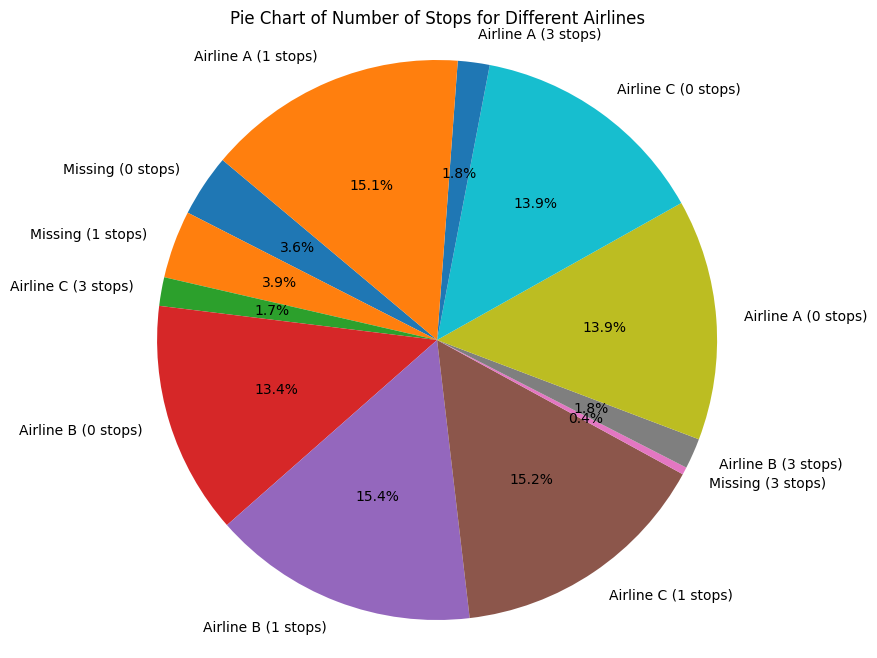

In [ ]:
from pyspark.sql.functions import count
stops_count = data.groupBy("Airline", "Number_of_Stops").agg(count("*").alias("Count"))

# Collect the data to the driver node
stops_count_collected = stops_count.collect()

# Prepare the data for plotting
labels = [f"{row['Airline']} ({row['Number_of_Stops']} stops)" for row in stops_count_collected]
sizes = [row['Count'] for row in stops_count_collected]

# Now let's plot the pie chart using Matplotlib
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart of Number of Stops for Different Airlines')
plt.show()

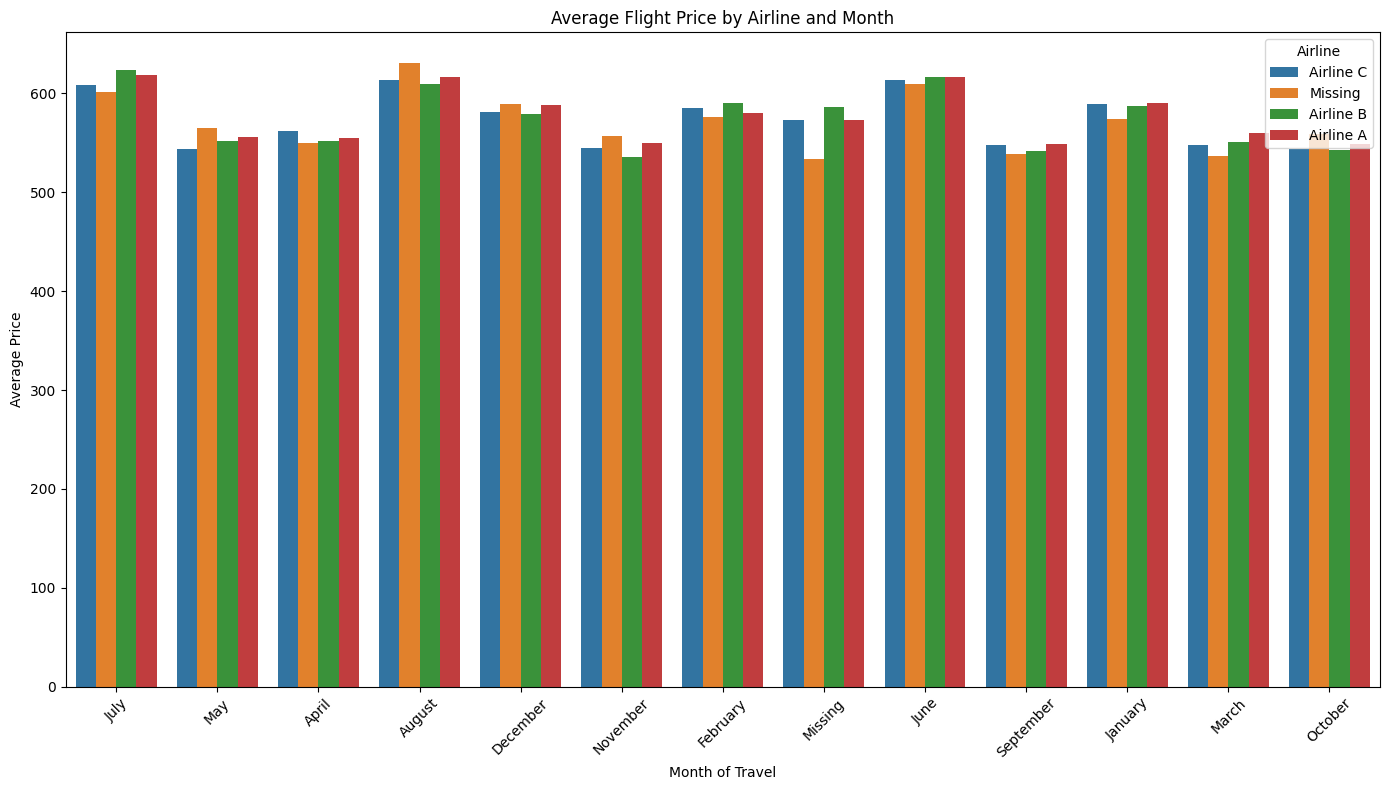

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

price_by_airline_month = data.groupBy("Airline", "Month_of_Travel").agg(avg("Flight_Price").alias("Average_Price"))

# Step 2: Collect the data into a Pandas DataFrame
price_pandas_df = price_by_airline_month.toPandas()

# Pivot the data for plotting
price_pivot_df = price_pandas_df.pivot(index='Month_of_Travel', columns='Airline', values='Average_Price')

# Step 3: Plot the data using Seaborn's barplot
plt.figure(figsize=(14, 8))

# If you have a lot of airlines, you might want to plot only a subset of them or use a different type of plot
sns.barplot(x='Month_of_Travel', y='Average_Price', hue='Airline', data=price_pandas_df)

plt.title('Average Flight Price by Airline and Month')
plt.xlabel('Month of Travel')
plt.ylabel('Average Price')
plt.legend(title='Airline')
plt.xticks(rotation=45)  # Rotate the x labels for better readability if needed
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()


Creating a new data frame with most significant features for modeling

We have seen the boxlot of number of stops and seen there are higher prices for the more number of stops so, we decided to create new column based on distance by giving certain criteria and creates column as flight category which has three types like 'short-haul', 'medium-haul', 'long-haul'

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType

# Convert the 'Distance' and 'Number_of_Stops' columns to integers
data = data.withColumn('Distance', col('Distance').cast(IntegerType()))
data = data.withColumn('Number_of_Stops', col('Number_of_Stops').cast(IntegerType()))

# Define a Python function that categorizes flights based on distance and number of stops
def categorize_flight(distance, stops):
    if distance < 3500 and stops == 0:
        return 'Short-haul'
    elif 3500 <= distance <= 6000 and stops <= 1:
        return 'Medium-haul'
    else:
        return 'Long-haul'
categorize_flight_udf = udf(categorize_flight, StringType())

# Create a new column with the flight category
data= data.withColumn('Flight_Category', categorize_flight_udf(col('Distance'), col('Number_of_Stops')))
data.show()


+---------+---------+-------------------+-------------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+------------------------+---------------+
|Flight_ID|  Airline|     Departure_City|       Arrival_City|Distance|Departure_Time|Arrival_Time|Duration|Aircraft_Type|Number_of_Stops|Day_of_Week|Month_of_Travel|Holiday_Season| Demand|Weather_Conditions|Passenger_Count|Promotion_Type|Fuel_Price|Flight_Price|fuel_price_distance|sqrt_fuel_price_distance|Flight_Category|
+---------+---------+-------------------+-------------------+--------+--------------+------------+--------+-------------+---------------+-----------+---------------+--------------+-------+------------------+---------------+--------------+----------+------------+-------------------+------------------------+---------------+
|       F1|Airline B|       

In [ ]:
selected_features = [
    'Demand', 'Number_of_Stops', 'Aircraft_Type',
    'Day_of_Week', 'Month_of_Travel', 'Holiday_Season', 'Weather_Conditions',
    'Promotion_Type', 'Departure_City', 'Arrival_City', 'sqrt_fuel_price_distance','Flight_Category'
]
data_significant = data.select(selected_features)

constructing a PySpark machine learning pipeline that indexes, one-hot encodes categorical columns, assembles all features into a single vector, and then applying these transformations to the dataset.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
categorical_columns = ['Demand', 'Aircraft_Type', 'Day_of_Week', 'Month_of_Travel','Holiday_Season', 'Weather_Conditions', 'Promotion_Type', 'Departure_City', 'Arrival_City', 'Flight_Category']
numerical_columns = ['sqrt_fuel_price_distance']
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index").fit(data_significant) for c in categorical_columns]
encoders = [OneHotEncoder(inputCol=idx.getOutputCol(), outputCol=idx.getOutputCol() + "_enc") for idx in indexers]
assemblerInputs = [c + "_index_enc" for c in categorical_columns] + numerical_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
pipeline_stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_stages)
data_transformed = pipeline.fit(data_significant).transform(data_significant)
data_transformed.show(5)

+-------+---------------+-------------+-----------+---------------+--------------+------------------+--------------+----------------+---------------+------------------------+---------------+------------+-------------------+-----------------+---------------------+--------------------+------------------------+--------------------+--------------------+------------------+---------------------+----------------+-----------------------+---------------------+-------------------------+------------------------+----------------------------+------------------------+------------------------+----------------------+-------------------------+--------------------+
| Demand|Number_of_Stops|Aircraft_Type|Day_of_Week|Month_of_Travel|Holiday_Season|Weather_Conditions|Promotion_Type|  Departure_City|   Arrival_City|sqrt_fuel_price_distance|Flight_Category|Demand_index|Aircraft_Type_index|Day_of_Week_index|Month_of_Travel_index|Holiday_Season_index|Weather_Conditions_index|Promotion_Type_index|Departure_City

In [ ]:
data_transformed.printSchema()

root
 |-- Demand: string (nullable = true)
 |-- Number_of_Stops: integer (nullable = true)
 |-- Aircraft_Type: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Month_of_Travel: string (nullable = true)
 |-- Holiday_Season: string (nullable = true)
 |-- Weather_Conditions: string (nullable = true)
 |-- Promotion_Type: string (nullable = true)
 |-- Departure_City: string (nullable = true)
 |-- Arrival_City: string (nullable = true)
 |-- sqrt_fuel_price_distance: double (nullable = true)
 |-- Flight_Category: string (nullable = true)
 |-- Demand_index: double (nullable = false)
 |-- Aircraft_Type_index: double (nullable = false)
 |-- Day_of_Week_index: double (nullable = false)
 |-- Month_of_Travel_index: double (nullable = false)
 |-- Holiday_Season_index: double (nullable = false)
 |-- Weather_Conditions_index: double (nullable = false)
 |-- Promotion_Type_index: double (nullable = false)
 |-- Departure_City_index: double (nullable = false)
 |-- Arrival_City_inde

Now we don't have flight price in this transformed data

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

data_with_id = data.withColumn("row_id", monotonically_increasing_id())
transformed_data_with_id = data_transformed.withColumn("row_id", monotonically_increasing_id())
final_data = transformed_data_with_id.join(data_with_id.select("row_id", "Flight_Price"), on=["row_id"], how="inner")
final_data = final_data.drop("row_id")
final_data = final_data.withColumn("Flight_Price", col("Flight_Price").cast(DoubleType()))

In [ ]:
final_data.show(5)
final_data.printSchema()

+-------+---------------+-------------+-----------+---------------+--------------+------------------+--------------+----------------+---------------+------------------------+---------------+------------+-------------------+-----------------+---------------------+--------------------+------------------------+--------------------+--------------------+------------------+---------------------+----------------+-----------------------+---------------------+-------------------------+------------------------+----------------------------+------------------------+------------------------+----------------------+-------------------------+--------------------+------------+
| Demand|Number_of_Stops|Aircraft_Type|Day_of_Week|Month_of_Travel|Holiday_Season|Weather_Conditions|Promotion_Type|  Departure_City|   Arrival_City|sqrt_fuel_price_distance|Flight_Category|Demand_index|Aircraft_Type_index|Day_of_Week_index|Month_of_Travel_index|Holiday_Season_index|Weather_Conditions_index|Promotion_Type_index|D

Linear Regresion

In [ ]:
train_data, test_data = final_data.randomSplit([0.8, 0.2])

In [ ]:
from pyspark.ml.regression import LinearRegression
lin_reg = LinearRegression(featuresCol='features', labelCol='Flight_Price')
lin_reg_model = lin_reg.fit(train_data)
predictions = lin_reg_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Flight_Price", predictionCol="prediction", metricName="rmse")
rmse_lr = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: %g" % rmse_lr)

Root Mean Squared Error (RMSE) on test data: 61.8


Decision Tree Regressor

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(featuresCol='features', labelCol='Flight_Price')
dt_model = dt_regressor.fit(train_data)
dt_predictions = dt_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="Flight_Price", predictionCol="prediction", metricName="rmse")
rmse_dtr = evaluator.evaluate(dt_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_dtr}")

Root Mean Squared Error (RMSE) on test data: 55.35188919971214


 Gradient Boossted Tree Regressor

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf_regressor = GBTRegressor(featuresCol="features", labelCol="Flight_Price")
rf_model = rf_regressor.fit(train_data)
rf_predictions = rf_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="Flight_Price",
    predictionCol="prediction",
    metricName="rmse"
)

# Calculate the RMSE
rmse_gbt = evaluator.evaluate(rf_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_gbt}")

Root Mean Squared Error (RMSE) on test data: 40.10117003679778


Isotonic Regression

In [ ]:
from pyspark.ml.regression import IsotonicRegression

ir_regressor = IsotonicRegression(featuresCol="features", labelCol="Flight_Price")
ir_model = ir_regressor.fit(train_data)
ir_predictions = ir_model.transform(test_data)

In [ ]:
rmse_ir = evaluator.evaluate(ir_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_ir}")

Root Mean Squared Error (RMSE) on test data: 163.0730391149828


Factorization machines regressor

In [ ]:
from pyspark.ml.regression import FMRegressor

fm_regressor = FMRegressor(featuresCol="features", labelCol="Flight_Price")
fm_model = fm_regressor.fit(train_data)
fm_predictions = fm_model.transform(test_data)

In [ ]:
rmse_fmr = evaluator.evaluate(fm_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_fmr}")

Root Mean Squared Error (RMSE) on test data: 124.65341639243252


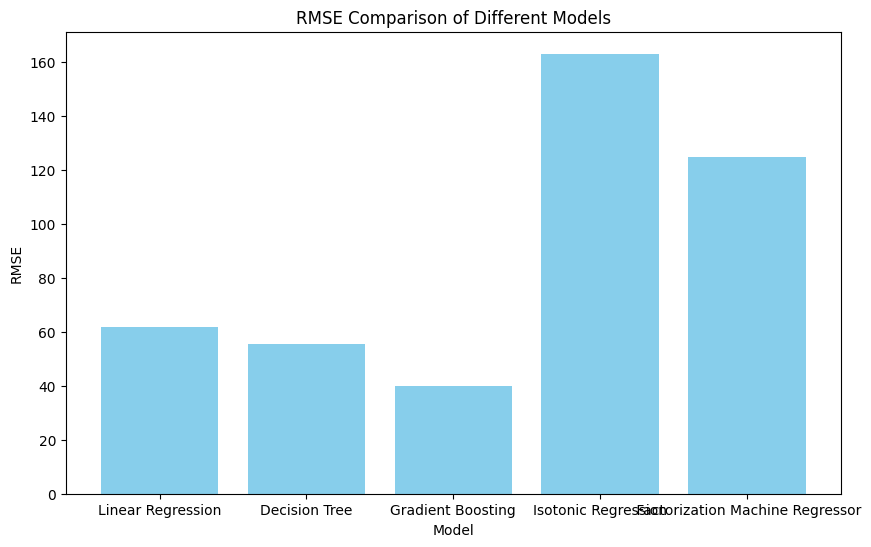

In [ ]:
import matplotlib.pyplot as plt

# RMSE values
model_names = ['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'Isotonic Regression', ' Factorization Machine Regressor']
rmse_values = [rmse_lr, rmse_dtr, rmse_gbt, rmse_ir,rmse_fmr]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, rmse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Different Models')
plt.show()


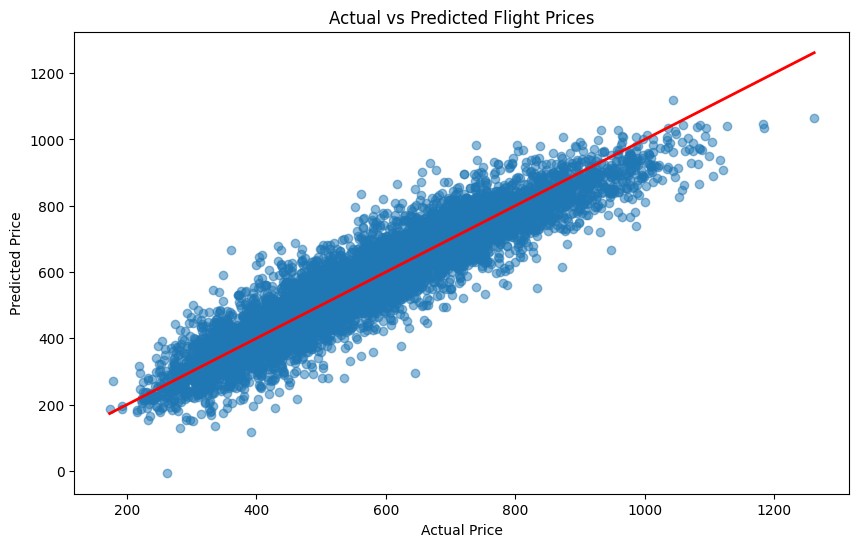

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'predictions' DataFrame to a Pandas DataFrame for plotting
# Note: This step assumes that your dataset is not too large to fit in memory as a Pandas DataFrame
pandas_df = predictions.select("Flight_Price", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Flight_Price'], pandas_df['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.plot([pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         [pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         color='red', lw=2)  # Adding a reference line
plt.show()


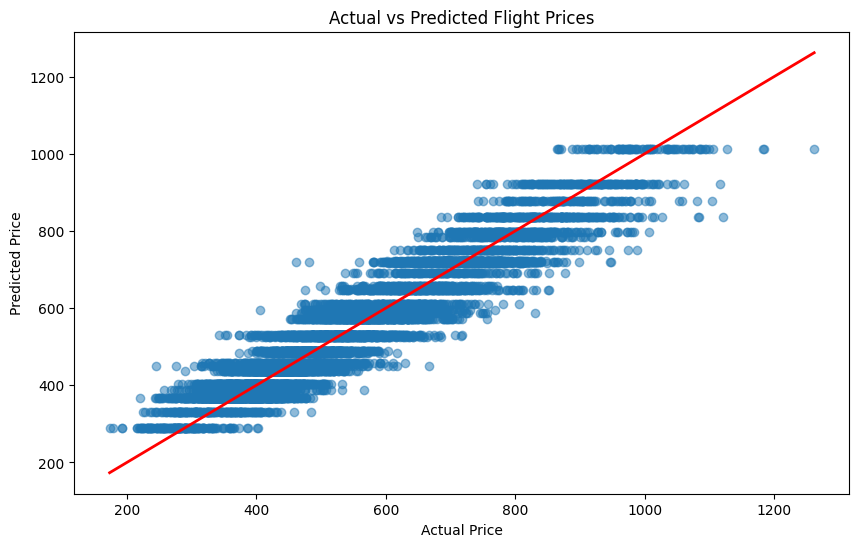

In [ ]:
import matplotlib.pyplot as plt

pandas_df = dt_predictions.select("Flight_Price", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Flight_Price'], pandas_df['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.plot([pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         [pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         color='red', lw=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

pandas_df = rf_predictions.select("Flight_Price", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Flight_Price'], pandas_df['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.plot([pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         [pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         color='red', lw=2)  # Adding a reference line
plt.show()

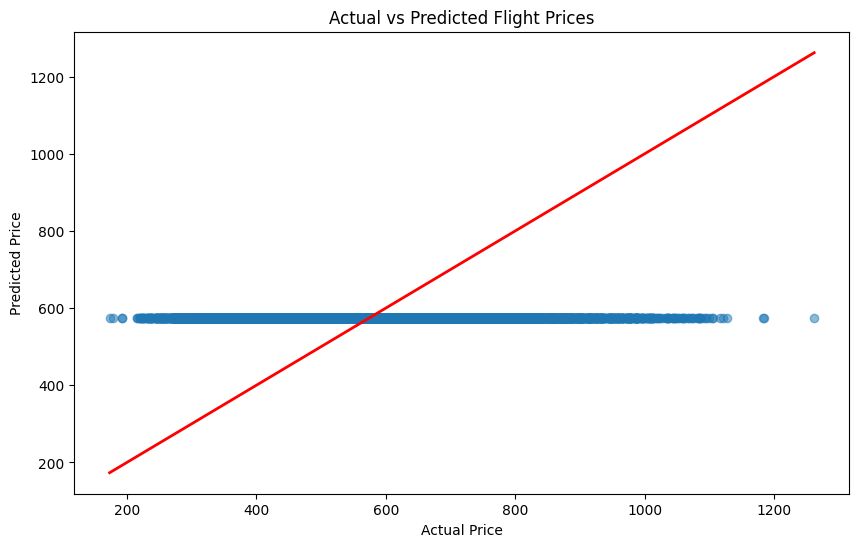

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'predictions' DataFrame to a Pandas DataFrame for plotting
# Note: This step assumes that your dataset is not too large to fit in memory as a Pandas DataFrame
pandas_df = ir_predictions.select("Flight_Price", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Flight_Price'], pandas_df['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.plot([pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         [pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         color='red', lw=2)  # Adding a reference line
plt.show()

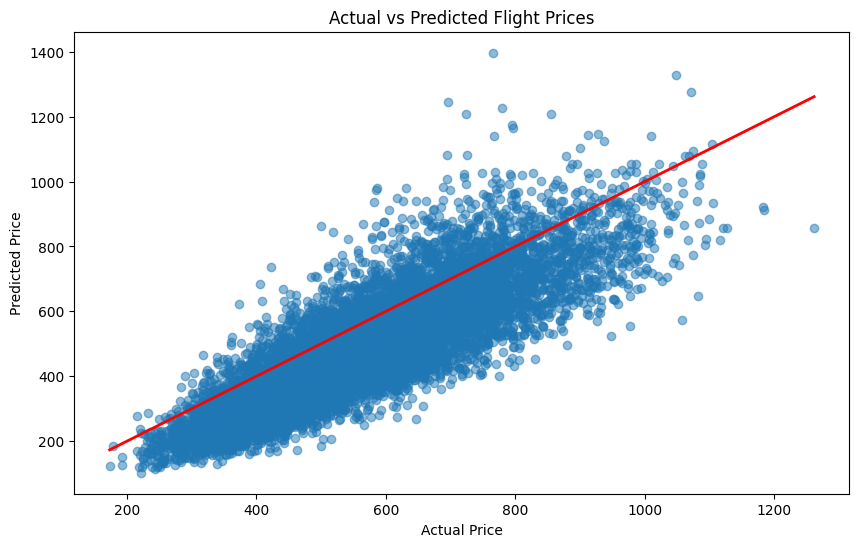

In [ ]:
import matplotlib.pyplot as plt

# Convert the 'predictions' DataFrame to a Pandas DataFrame for plotting
# Note: This step assumes that your dataset is not too large to fit in memory as a Pandas DataFrame
pandas_df = fm_predictions.select("Flight_Price", "prediction").toPandas()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Flight_Price'], pandas_df['prediction'], alpha=0.5)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Flight Prices')
plt.plot([pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         [pandas_df['Flight_Price'].min(), pandas_df['Flight_Price'].max()],
         color='red', lw=2)  # Adding a reference line
plt.show()

We decided to tune hyperparameters for linear regression, Decision Tree regressor and Gradient Boosting. Not the other two methods becuase they give larger RMSE values.

Tuning linear model

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lin_reg.regParam, [0.1, 0.01, 0.001])
             .addGrid(lin_reg.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Flight_Price", metricName="rmse")

crossval = CrossValidator(estimator=lin_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel

In [ ]:
predictions_lr_tuned = best_model.transform(test_data)
rmse_lr_tuned = evaluator.evaluate(predictions_lr_tuned)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse_lr_tuned}")
print(f"Best parameters: regParam - {best_model._java_obj.getRegParam()}, elasticNetParam - {best_model._java_obj.getElasticNetParam()}")

Root Mean Squared Error (RMSE) on test data: 44.17793352241557
Best parameters: regParam - 0.1, elasticNetParam - 1.0
